
## Wiener filtering for mass mapping example on MICE data


Instructions for the C++ code are, 

to compile from within the source directory 

```
cd src/
g++ -o wiener2d wiener2d.cpp -std=c++11 -I/usr/local/include -L/usr/local/lib -lcfitsio -lfftw3 -lm
```

to run the executable

```
rm wiener.fits && ./wiener2d
```

the hard-coded input fits files are
```
mice_g1_map.fits              -> the binned g1 map 
mice_g2_map.fits              -> the binned g2 map
mice_cosmosis_ps1d_kappa.fits -> the 1d powerspectrum for the mice map based on the cosmosis module
mice_noisecov_map.fits        -> the noise covariance map having a DES-like mask
```
the wiener2d executable outputs the Wiener estimate of the convergence to the fits file

```
src/wiener.fits
```


In [1]:
%matplotlib inline

import numpy as np
from astropy.io import fits
from scipy import ndimage
import math
import matplotlib.pyplot as plt


In [2]:
plt.rcParams['figure.figsize'] = (15, 5); plt.rcParams.update({'font.size': 13});


shear map size (256, 256)
power spectrum length (182,)


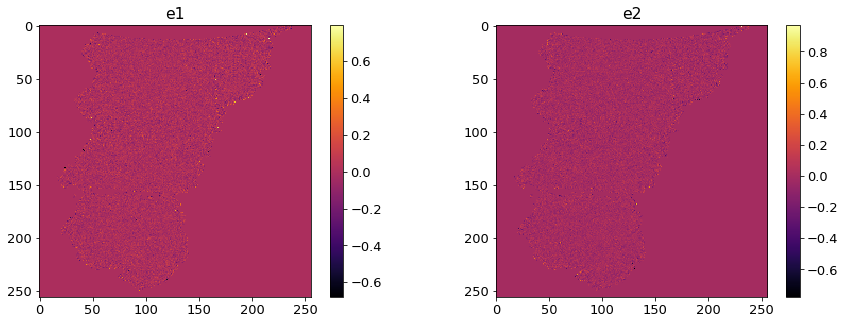

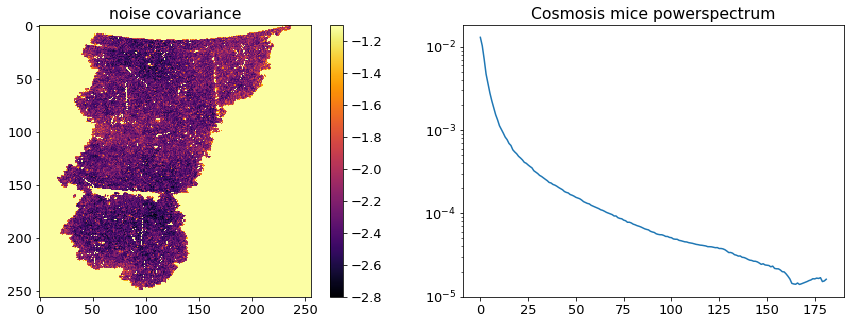

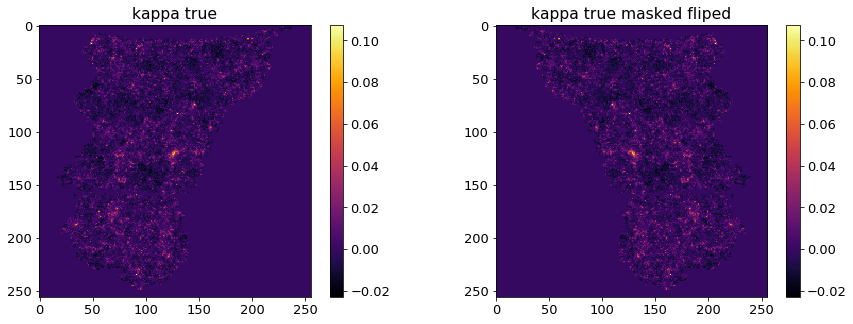

In [3]:
# read data

# load noisy shear 
e1 = fits.getdata('../data/mice_g1_map.fits')
e2 = fits.getdata('../data/mice_g2_map.fits')

npix = e1.shape[0]
print('shear map size', e1.shape)

# load noise covariance
Ncov = fits.getdata('../data/mice_noisecov_map.fits')
Ncov = Ncov.reshape([npix, npix])

# load power spectrum
ps1d = fits.getdata('../data/mice_cosmosis_ps1d_kappa.fits')
print('power spectrum length', ps1d.shape)

# load true kappa
ktr = fits.getdata('../data/true_kappa_map.fits')
index = np.where(Ncov<1e2)
ktr_mask = np.zeros((npix,npix))
ktr_mask[index] = ktr[index]
ktr_mask_flip = np.flip(ktr_mask, 1)

# plot maps
fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(e1, interpolation='none', cmap='inferno') 
ax1.set_title('e1'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(e2, interpolation='none', cmap='inferno') 
ax2.set_title('e2'), plt.colorbar(cax2, ax=ax2)
plt.show()

fig2, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(np.log10(Ncov), interpolation='none', cmap='inferno',vmin=-2.8,vmax=-1.1) 
ax1.set_title('noise covariance'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.plot(ps1d) 
ax2.set_title('Cosmosis mice powerspectrum'), ax2.set_yscale('log')
plt.show()

fig3, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(ktr, interpolation='none', cmap='inferno') 
ax1.set_title('kappa true'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow((ktr_mask_flip), interpolation='none', cmap='inferno') 
ax2.set_title('kappa true masked fliped'), plt.colorbar(cax2, ax=ax2)

plt.show()


___

### Kaiser-Squires inversion

In [4]:

# Compute once the Fourier kernels for the transform
k1, k2 = np.meshgrid(np.fft.fftfreq(npix), np.fft.fftfreq(npix))
denom = k1*k1 + k2*k2
denom[0, 0] = 1  # avoid division by 0
kernel1 = (k1**2 - k2**2)/denom
kernel2 = (2*k1*k2)/denom

def kappa_to_gamma(kappa):
    k = np.fft.fft2(kappa)
    g1 = np.fft.ifft2(kernel1 * k) 
    g2 = np.fft.ifft2(kernel2 * k)
    return g1.real - g2.imag, g2.real + g1.imag 

def gamma_to_kappa(gam1, gam2):
    g = gam1 + 1j*gam2
    return np.fft.ifft2((kernel1 - 1j*kernel2)* np.fft.fft2(g))


In [5]:
# # # compute the Kaiser-Squares map

kks = gamma_to_kappa(e1, e2)
kkss = ndimage.filters.gaussian_filter(kks.real, sigma = 2)
kkss_mask = np.zeros_like(kkss)
kkss_mask[index] = kkss[index]
kkss_mask_flip = np.flip(kkss_mask, 1)

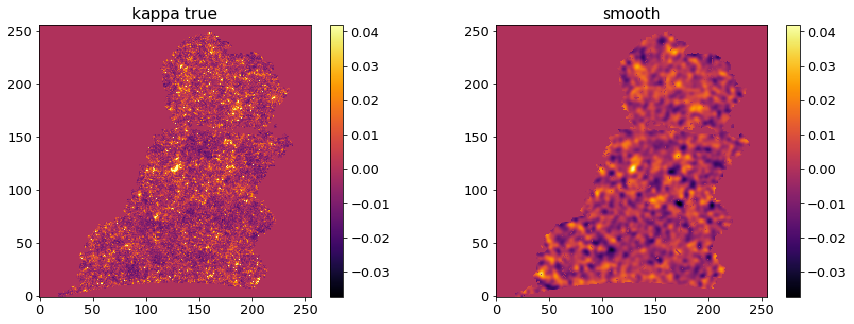

In [6]:
# # # show smoothed KS map

vvmin = np.min(kkss)
vvmax = np.max(kkss)
fig2, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(ktr_mask_flip, interpolation='none', cmap='inferno', origin='lower', vmin = vvmin, vmax = vvmax) 
ax1.set_title('kappa true'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kkss_mask_flip, interpolation='none', cmap='inferno', origin='lower', vmin = vvmin, vmax = vvmax) 
ax2.set_title('smooth'), plt.colorbar(cax2, ax=ax2)

plt.show()


___

### Wiener filter 

In [7]:
# wiener filtering inversion

# define the kappa to shear operator
def H_operator(ka_map, kb_map):
    
    # ka_map and kb_map should be of the same size
    [nx,ny] = ka_map.shape
    
    ka_map_fft = np.fft.fft2(ka_map)
    kb_map_fft = np.fft.fft2(kb_map)
    
    f1, f2 = np.meshgrid(np.fft.fftfreq(ny),np.fft.fftfreq(nx))
    
    p1 = f1 * f1 - f2 * f2
    p2 = 2 * f1 * f2
    f2 = f1 * f1 + f2 * f2
    f2[0,0] = 1 # avoid division with zero
    kafc =  (p1 * ka_map_fft - p2 * kb_map_fft) / f2
    kbfc =  (p1 * kb_map_fft + p2 * ka_map_fft) / f2
    
    g1_map = np.fft.ifft2(kafc).real
    g2_map = np.fft.ifft2(kbfc).real
    
    return g1_map, g2_map


# define the shear to convergence operator
def H_adjoint(g1_map, g2_map):
    
    [nx,ny] = g1_map.shape
    
    g1_map_ifft = np.fft.ifft2(g1_map)
    g2_map_ifft = np.fft.ifft2(g2_map)
    
    f1, f2 = np.meshgrid(np.fft.fftfreq(ny),np.fft.fftfreq(nx))
    
    p1 = f1 * f1 - f2 * f2
    p2 = 2 * f1 * f2
    f2 = f1 * f1 + f2 * f2
    f2[0,0] = 1
    g1fc =  (p1 * g1_map_ifft + p2 * g2_map_ifft) / f2
    g2fc =  (p1 * g2_map_ifft - p2 * g1_map_ifft) / f2
    
    kappa1 = np.fft.fft2(g1fc).real
    kappa2 = np.fft.fft2(g2fc).real
    
    return kappa1, kappa2

def compute_spectrum_map(Px,size):
    power_map = np.zeros((size, size), dtype = float)
    k_map =  np.zeros((size, size), dtype = float)

    for (i,j), val in np.ndenumerate(power_map):

        k1 = i - size/2.0
        k2 = j - size/2.0
        k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

        if k_map[i,j]==0:
            #print(i,j)
            power_map[i, j] = 1e-15
        else:
            #print(k_map[i, j])
            power_map[i, j] = Px[int(k_map[i, j])]
    return power_map


def prox_wiener_filtering(gamma1, gamma2, Px_map, Ncv):
        
    # initiallize
    nx = gamma1.shape[0]
    xg = np.zeros((nx,nx)) + 1j * np.zeros((nx,nx))
    
    # find the minimum noise variance
    tau = np.min(Ncv)
    
    # set the step size
    eta = 1.83 * tau
    
    # compute signal coefficient
    Esn = eta / Ncv
    
    # calculate the wiener filter coefficients
    Wfc = Px_map / (Px_map + eta)
    
    n_iter = 100
    for n in range(n_iter):
        t1,t2 = H_operator(xg.real, xg.imag)                              # H * xg
        t1,t2 = H_adjoint(Esn*(gamma1 - t1), Esn*(gamma2 - t2))           # H^T(eta / Sn * (y- H * xg))
        t = xg + (t1 + 1j*t2)                                             # xg + H^T(eta / Sn * (y- H * xg))
        
        xg = np.fft.ifft2(np.fft.fftshift(Wfc * np.fft.fftshift(np.fft.fft2(t)))) # wiener filtering in fourier space
        
    return xg.real, xg.imag

(kwnr,kpwb) = prox_wiener_filtering(e1, e2, compute_spectrum_map(ps1d,npix), Ncov)
    
kwnr_mask = np.zeros_like(kwnr)
kwnr_mask[index] = kwnr[index]
kwnr_mask_flip = np.flip(kwnr_mask, -1)

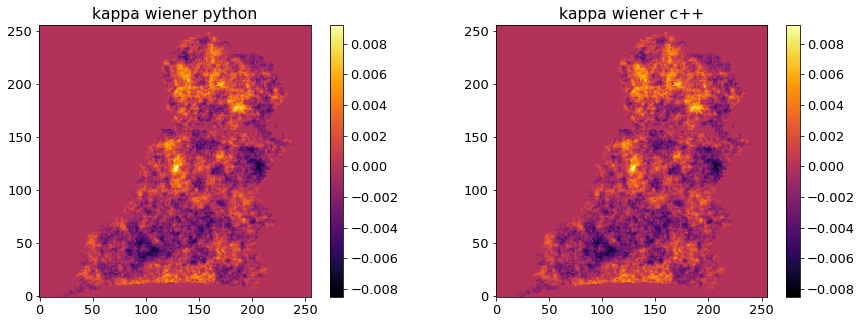

In [8]:
# compare wiener c++ and wiener python implementations
try: 
    kwrc = fits.getdata('../src/wiener.fits') # this file is the output of the c++ code 
    
    kwrc_mask = np.zeros_like(kwrc)
    kwrc_mask[index] = kwrc[index]
    kwrc_mask_flip = np.flip(kwrc_mask, -1)
    
    vvmin = np.min(kwrc)
    vvmax = np.max(kwrc)
    fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    cax1 = ax1.imshow(kwnr_mask_flip, interpolation='none', cmap='inferno', origin='lower', vmin = vvmin, vmax = vvmax)  
    ax1.set_title('kappa wiener python'), plt.colorbar(cax1, ax=ax1)
    cax2 = ax2.imshow(kwrc_mask_flip, interpolation='none', cmap='inferno', origin='lower', vmin = vvmin, vmax = vvmax) 
    ax2.set_title('kappa wiener c++'), plt.colorbar(cax2, ax=ax2)

    plt.show()
except:
    print('Wiener filtering c++ map missing')

___